In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.optimize import bisect
from scipy.signal import find_peaks

# ========== CONFIGURAÇÕES ==========
plt.style.use('default')
cmap = 'jet'

# ========== LEITURA DOS DADOS ==========
arquivo = 'C:\\penelope\\KERNEL\\3d-dose2.dat'
Arq = np.loadtxt(arquivo)

i_max, j_max, k_max = map(int, np.max(Arq[:, 5:8], axis=0))
x_min, x_max = Arq[:, 0].min(), Arq[:, 0].max()
y_min, y_max = Arq[:, 1].min(), Arq[:, 1].max()
z_min, z_max = Arq[:, 2].min(), Arq[:, 2].max()

VoxelSize = [(x_max - x_min)/i_max, (y_max - y_min)/j_max, (z_max - z_min)/k_max]
EscalaX = np.linspace(x_min + VoxelSize[0]/2, x_max - VoxelSize[0]/2, i_max)
EscalaY = np.linspace(y_min + VoxelSize[1]/2, y_max - VoxelSize[1]/2, j_max)
EscalaZ = np.linspace(z_min + VoxelSize[2]/2, z_max - VoxelSize[2]/2, k_max)

Dose = np.zeros((i_max, j_max, k_max))
for linha in Arq:
    i, j, k = int(linha[5]) - 1, int(linha[6]) - 1, int(linha[7]) - 1
    Dose[i, j, k] = linha[3]

# ========== FILTRO ==========
mask_x = (EscalaX >= -2) & (EscalaX <= 2)
mask_y = (EscalaY >= -2) & (EscalaY <= 2)
mask_z = EscalaZ < 20

Dose_filt = Dose[mask_x][:, mask_y][:, :, mask_z]
EscalaX_filt = EscalaX[mask_x]
EscalaY_filt = EscalaY[mask_y]
EscalaZ_filt = EscalaZ[mask_z]
max_dose_original = np.max(Dose_filt)




Deslocamento necessário: 0.12 cm


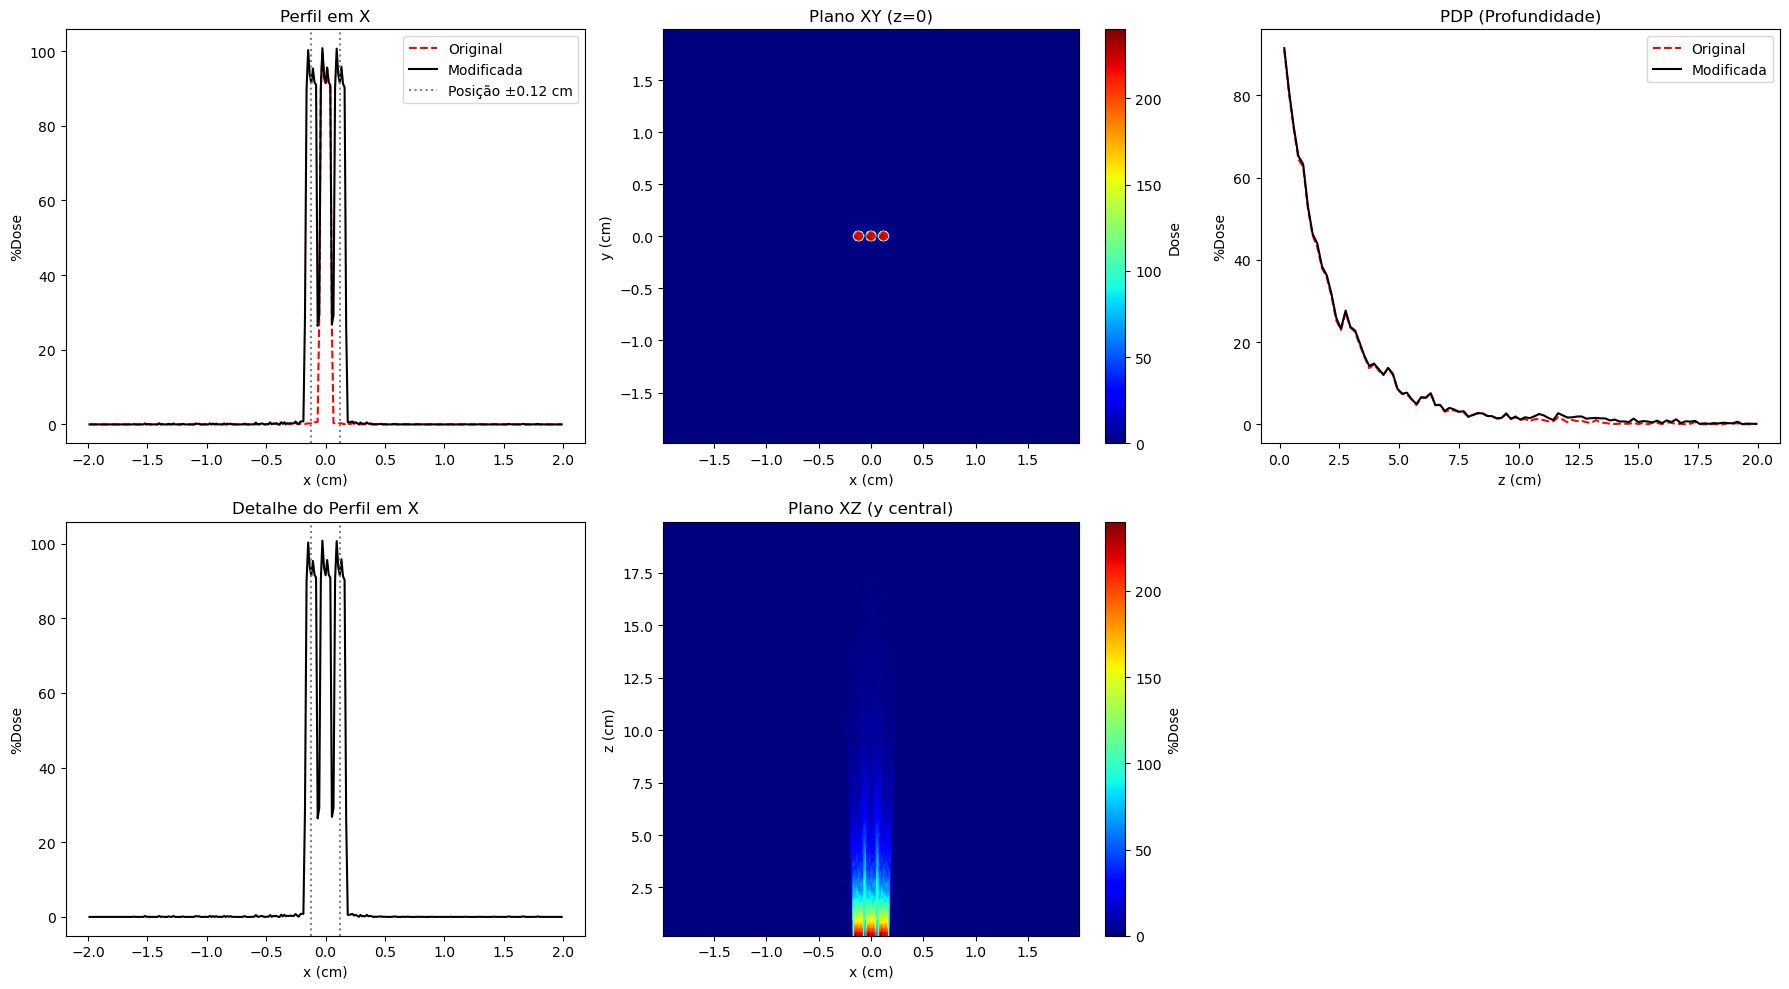

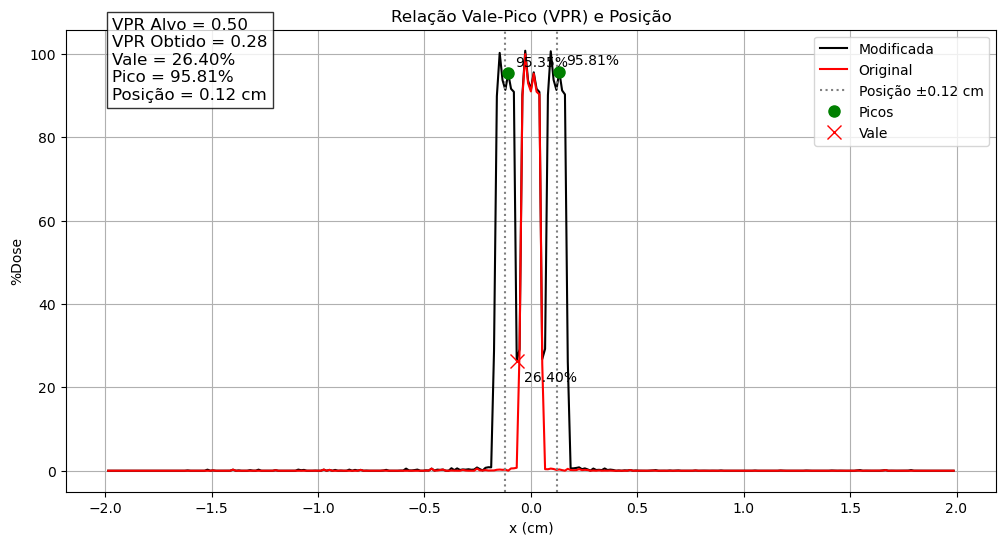

In [3]:
# ========== VPR (CORRIGIDA) ==========
def calcular_vpr(distancia_x):
    delta_voxel = int(distancia_x / VoxelSize[0])
    if delta_voxel >= Dose_filt.shape[0] or delta_voxel <= 0:
        return 0.0, None, None, None
    #Converter a distância física (distancia_x, em cm) para voxels. VoxelSize[0]: Tamanho do voxel na direção x (em cm).
    #Evitar deslocamentos inválidos: Se delta_voxel for maior ou
    #igual ao número de voxels em x (Dose_filt.shape[0]), o deslocamento ultrapassa a matriz.
    #Se delta_voxel for ≤ 0, o deslocamento é fisicamente impossível. Retorna 0 e none para indicar uma falha

    Dose_pos = np.zeros_like(Dose_filt)
    Dose_neg = np.zeros_like(Dose_filt)
    Dose_pos[delta_voxel:, :, :] = Dose_filt[:-delta_voxel]
    Dose_neg[:-delta_voxel, :, :] = Dose_filt[delta_voxel:]
    Dose_comb = Dose_filt + Dose_pos + Dose_neg
    #Cria versões deslocadas da dose original, a Dose_pos é deslocada para a direita.
    #delta_voxel:: Corta os primeiros delta_voxel voxels no início. 
    #delta_voxel: Mantém os voxels originais até o ponto onde o deslocamento é aplicado.
    #Dose combinada é a matriz com a duplicação sobreposta, formando operfil
    
    j_central = Dose_comb.shape[1] // 2
    dose_x_mod = 100 * Dose_comb[:, j_central, 0] / max_dose_original
    #perfil de doses
    
    peaks, _ = find_peaks(dose_x_mod, distance=1,prominence=1)
    #econtra picos, distancia em voxesl e proeminencia em porcentagem de dose
    #até aqui interferencia da dose na matriz duplicada.
    
    if len(peaks) >= 2:
        idx_pos = peaks[np.argmin(np.abs(EscalaX_filt[peaks] - distancia_x))]
        idx_neg = peaks[np.argmin(np.abs(EscalaX_filt[peaks] + distancia_x))]
    else:
        idx_pos = np.argmin(np.abs(EscalaX_filt - distancia_x))
        idx_neg = np.argmin(np.abs(EscalaX_filt + distancia_x))
    #verifica se há pelo menos dois picos
    #calcula a diferença entre as posições dos picos (em cm) e o alvo +distancia_x.
    #np.abs encontra o pico mais próximo da posição desejada 
    #idx_pos e idx_neg é o indice mais próximo da da distancia_x desejada
    
    if idx_neg < idx_pos:
        regiao_vale = dose_x_mod[idx_neg:idx_pos]
    else:
        regiao_vale = dose_x_mod[idx_pos:idx_neg]
    #idx_neg < idx_pos: Verifica se o pico negativo está à esquerda do pico positivo.
    #regiao_vale: Define a região entre os dois picos como a área onde o vale será buscado.
    
    idx_vale_rel = np.argmin(regiao_vale)
    idx_vale = idx_neg + idx_vale_rel if idx_neg < idx_pos else idx_pos + idx_vale_rel
    #identificação do vale, encontra o indice minimo dentro da região fornecida e idx_vale
    #converte para um valor absoluto dentro da escala X
    
    vale = dose_x_mod[idx_vale]
    pico = max(dose_x_mod[idx_pos], dose_x_mod[idx_neg])
    #definição do vale e pico 
    
    vpr = vale / pico if pico != 0 else 0.0
    return vpr, idx_pos, idx_neg, idx_vale
    #calculo da relação vp
# ========== INPUT E BUSCA DO DESLOCAMENTO ==========
vpr_alvo = float(input("Digite a relação Vale-Pico (VPR) desejada: "))

def encontrar_deslocamento(vpr_alvo):
    def f(d):
        vpr, _, _, _ = calcular_vpr(d)  # Usar 'd' diretamente, não 'deslocamento_otimo'
        return vpr - vpr_alvo
    # Criar uma função que retorne a diferença entre a VPR calculada para um deslocamento d e a VPR alvo.
    d_min, d_max = 0.1, EscalaX_filt[-1] - 0.1
    try:
        return bisect(f, d_min, d_max, xtol=0.01)
    except ValueError:
        print("Erro: VPR não alcançável!")
        return None
    #analisar isso
deslocamento_otimo = encontrar_deslocamento(vpr_alvo)

# ========== PLOTAGEM COMPLETA ==========
if deslocamento_otimo is not None:
    print(f"\nDeslocamento necessário: {deslocamento_otimo:.2f} cm")
    
    # Recálculo da dose combinada
    delta_voxel = int(deslocamento_otimo / VoxelSize[0])
    Dose_pos = np.zeros_like(Dose_filt)
    Dose_neg = np.zeros_like(Dose_filt)
    Dose_pos[delta_voxel:, :, :] = Dose_filt[:-delta_voxel]
    Dose_neg[:-delta_voxel, :, :] = Dose_filt[delta_voxel:]
    Dose_comb = Dose_filt + Dose_pos + Dose_neg

    # Dados para plots
    i_central = Dose_comb.shape[0] // 2
    j_central = Dose_comb.shape[1] // 2
    dose_x_mod = 100 * Dose_comb[:, j_central, 0] / max_dose_original
    dose_x_orig = 100 * Dose_filt[:, j_central, 0] / max_dose_original
    dose_z_mod = 100 * Dose_comb[i_central, j_central, :] / max_dose_original
    dose_z_orig = 100 * Dose_filt[i_central, j_central, :] / max_dose_original

    # Recupera os índices do pico e vale para o VPR final
    vpr_final, idx_pos, idx_neg, idx_vale = calcular_vpr(deslocamento_otimo)
    
    # Calcula valores específicos de pico e vale para mostrar informações detalhadas
    if idx_pos is not None and idx_neg is not None and idx_vale is not None:
        pico_pos = dose_x_mod[idx_pos]
        pico_neg = dose_x_mod[idx_neg]
        pico_max_valor = max(pico_pos, pico_neg)
        vale = dose_x_mod[idx_vale]
    else:
        pico_pos = pico_neg = pico_max_valor = vale = 0

    # Gráficos
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # Perfil em X
    axs[0,0].plot(EscalaX_filt, dose_x_orig, 'r--', label='Original')
    axs[0,0].plot(EscalaX_filt, dose_x_mod, 'k-', label='Modificada')
    axs[0,0].axvline(deslocamento_otimo, color='gray', linestyle=':', label=f'Posição ±{deslocamento_otimo:.2f} cm')
    axs[0,0].axvline(-deslocamento_otimo, color='gray', linestyle=':')
    axs[0,0].set(title='Perfil em X', xlabel='x (cm)', ylabel='%Dose')
    axs[0,0].legend()
    
    # Plano XY
    img1 = axs[0,1].imshow(Dose_comb[:,:,0].T, cmap=cmap, origin='lower', 
                          extent=[EscalaX_filt[0], EscalaX_filt[-1], EscalaY_filt[0], EscalaY_filt[-1]], aspect='auto')
    fig.colorbar(img1, ax=axs[0,1], label='Dose')
    axs[0,1].set(title='Plano XY (z=0)', xlabel='x (cm)', ylabel='y (cm)')
    
    # PDP
    axs[0,2].plot(EscalaZ_filt, dose_z_orig, 'r--', label='Original')
    axs[0,2].plot(EscalaZ_filt, dose_z_mod, 'k-', label='Modificada')
    axs[0,2].set(title='PDP (Profundidade)', xlabel='z (cm)', ylabel='%Dose')
    axs[0,2].legend()
    
    # Detalhe do perfil em X
    axs[1,0].plot(EscalaX_filt, dose_x_mod, 'k-')
    axs[1,0].axvline(deslocamento_otimo, color='gray', linestyle=':')
    axs[1,0].axvline(-deslocamento_otimo, color='gray', linestyle=':')
    axs[1,0].set(title='Detalhe do Perfil em X', xlabel='x (cm)', ylabel='%Dose')
    
    # Plano XZ
    img2 = axs[1,1].imshow(Dose_comb[:,j_central,:].T, cmap=cmap, origin='lower',
                          extent=[EscalaX_filt[0], EscalaX_filt[-1], EscalaZ_filt[0], EscalaZ_filt[-1]], aspect='auto')
    fig.colorbar(img2, ax=axs[1,1], label='%Dose')
    axs[1,1].set(title='Plano XZ (y central)', xlabel='x (cm)', ylabel='z (cm)')
    
    axs[1,2].axis('off')
    plt.tight_layout()
    plt.show()
    
    # ========== PLOT DO GRÁFICO DA VPR ==========
    plt.figure(figsize=(12, 6))
    plt.plot(EscalaX_filt, dose_x_mod, 'k-', label='Modificada')
    plt.plot(EscalaX_filt, dose_x_orig, 'r-', label='Original')
    plt.axvline(deslocamento_otimo, color='gray', linestyle=':', label=f'Posição ±{deslocamento_otimo:.2f} cm')
    plt.axvline(-deslocamento_otimo, color='gray', linestyle=':')
    plt.grid(True)
    
    # Apenas plotar pontos se os índices são válidos
    if idx_pos is not None and idx_neg is not None and idx_vale is not None:
        # Determinar qual pico tem o valor máximo
        pico_pos = dose_x_mod[idx_pos]
        pico_neg = dose_x_mod[idx_neg]
        pico_max_idx = idx_pos if pico_pos >= pico_neg else idx_neg
        pico_max_valor = max(pico_pos, pico_neg)
        
        # Plotar pontos
        plt.plot(EscalaX_filt[idx_pos], pico_pos, 'go', markersize=8, label='Picos')
        plt.plot(EscalaX_filt[idx_neg], pico_neg, 'go', markersize=8)
        plt.plot(EscalaX_filt[idx_vale], vale, 'rx', markersize=10, label='Vale')
        
        # Adicionar valores numéricos aos pontos
        plt.annotate(f'{pico_pos:.2f}%', (EscalaX_filt[idx_pos], pico_pos), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
        plt.annotate(f'{pico_neg:.2f}%', (EscalaX_filt[idx_neg], pico_neg), 
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
        plt.annotate(f'{vale:.2f}%', (EscalaX_filt[idx_vale], vale), 
                    xytext=(5, -15), textcoords='offset points', fontsize=10)
    
    # Adicionar informações do VPR
    plt.text(0.05, 0.85, 
             f'VPR Alvo = {vpr_alvo:.2f}\n'
             f'VPR Obtido = {vpr_final:.2f}\n'
             f'Vale = {vale:.2f}%\n'
             f'Pico = {pico_max_valor:.2f}%\n'
             f'Posição = {deslocamento_otimo:.2f} cm', 
             transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.title('Relação Vale-Pico (VPR) e Posição')
    plt.xlabel('x (cm)')
    plt.ylabel('%Dose')
    plt.grid(True)
    plt.legend()
    plt.show()

else:
    print("Não foi possível encontrar um deslocamento válido.")